# 1. Preparing dataset

- 변수 정보
    - Passengerld: 승객번호
    - Survived: 생존여부 (0: 사망, 1: 생존) 
    - Pclass: 배의 클래스(1>2>3) 
    - Name: 승객이름
    - Sex: 성별
    - Age: 승객 나이 
    - SibSp: 형제, 자매, 배우자의 수 
    - Parch: 부모, 자녀 수 
    - Ticket: 티켓번호 
    - Fare: 요금 
    - Cabin: 객실번호 
    - Embarked: 출발지 (C: 셰르부르, S: 사우샘프턴, Q: 퀸즈타운)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error, classification_report
from sklearn import  model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from vecstack import stacking, StackingTransformer
from xgboost import XGBClassifier
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from sklearn.linear_model import LogisticRegression

plt.rcParams['font.family'] = 'Nanum Gothic'

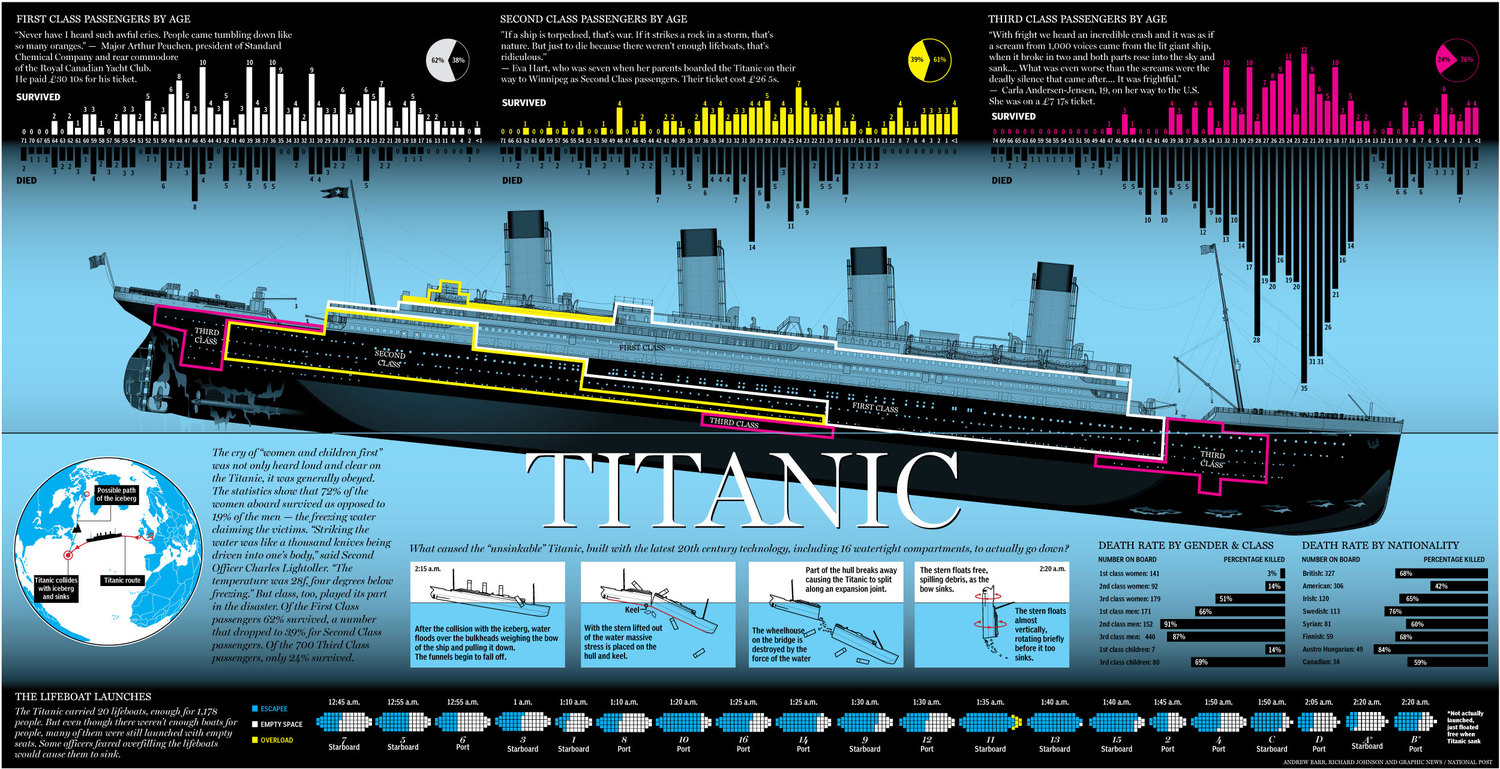

In [2]:
# titanic dataframe 생성
titan_df = pd.read_csv('titanic.csv')

In [3]:
# data 확인 
titan_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# titan dataframe infomation
titan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 변수 분류
    - Categorical(범주형): Survived, Sex, and Embarked. Ordinal: Pclass.
    - Continous(연속형): Age, Fare
    - Discrete(이산형): SibSp, Parch
> 7개의 변수는 integer or floats / 5개의 변수는 strings (object).

In [5]:
# numerical 변수 기술통계
titan_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- train data의 표본 샘플은 타이나닉호에 탑승한 실제 승객 수(2,224명)의 40%인 891명이다. 
- `표본 샘플의 생존율은 약 38%이다.`
- `지불 요금은 상당히 다양하게 나타나며, 512달러 만큼 높은 요금을 지불하는 경우는 거의 없었다.(1% 미만)` 
- `65-80세 범위에 속하는 노인은 거의 없다. (1% 미만)`

In [6]:
# Categorical 변수 기술통계 
titan_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


- 이름은 중복값이 존재하지 않는 고유값이다. (freq = 1)
- 승객 중 65%는 남성이었다. (577/891)
- 객실번호에 중복값이 다수인 것으로 보아, 여러명의 승객이 객실을 공유한 것으로 파악된다. (Cabin)
- 대부분의 승객이 사우샘프턴에서 탑승했다. (Embarked=S)
- 티겟번호 또한 중복 비율이 높다.(23%) (210/891)

In [7]:
# 결측치 확인 
titan_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Age: 177개의 결측치 존재 
- Cabin: 687개의 결측치 존재 
- Embarked: 2개의 결측치 존재 

#### Cabin > Age > Embarked 순으로 결측치 존재

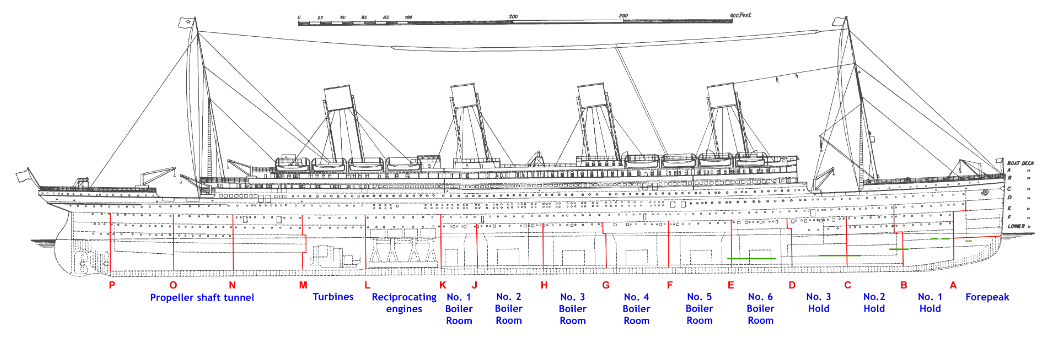

### PassengerId, Cabin, Name, Ticket 열 제거 
1. Cabin: 위 사진에서 A-P 번호는 각 객실번호(Cabin)의 앞자리에 붙은 객실 구분 번호를 뜻함. 하지만 각 객실번호가 어떤 Pclass에 속하는 지 파악 불가하며 여러명의 승객이 같은 객실을 공유했다는 점에서 이것이 생존여부에 미친 영향을 확인하기 어렵다고 판단 
  
2. Name: Mr, Miss와 같은 호칭을 통해서 승객들의 성별, 연령대를 파악할 수 있으나 이러한 정보는 이미 Age, Sex 컬럼에서 제시하고 있으므로 삭제
    
3. Ticket: 중복된 값이 다수 존재함에 따라 Ticket 번호가 생존여부에 미친 영향을 파악하기 어려울 것이라 판단 후 삭제 
  
> 따라서 해당 컬럼들을 제외하고 Pclass, Sex, Age, SibSp, Parch, Fare, Embarked 변수와 우리가 예측하고자 하는 값인 Survived 변수 간에 어떠한 관계가 있는 지 시각화 후 모델링

## Feature Importance

#### 파생변수(Family) 미포함

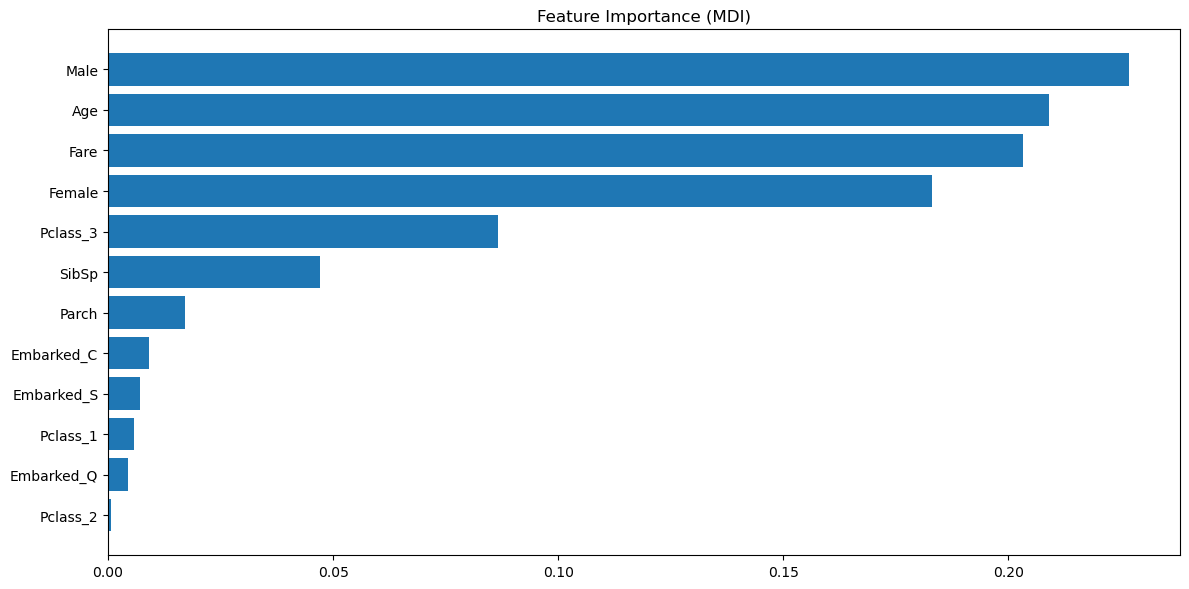

#### 파생변수(Family) 포함

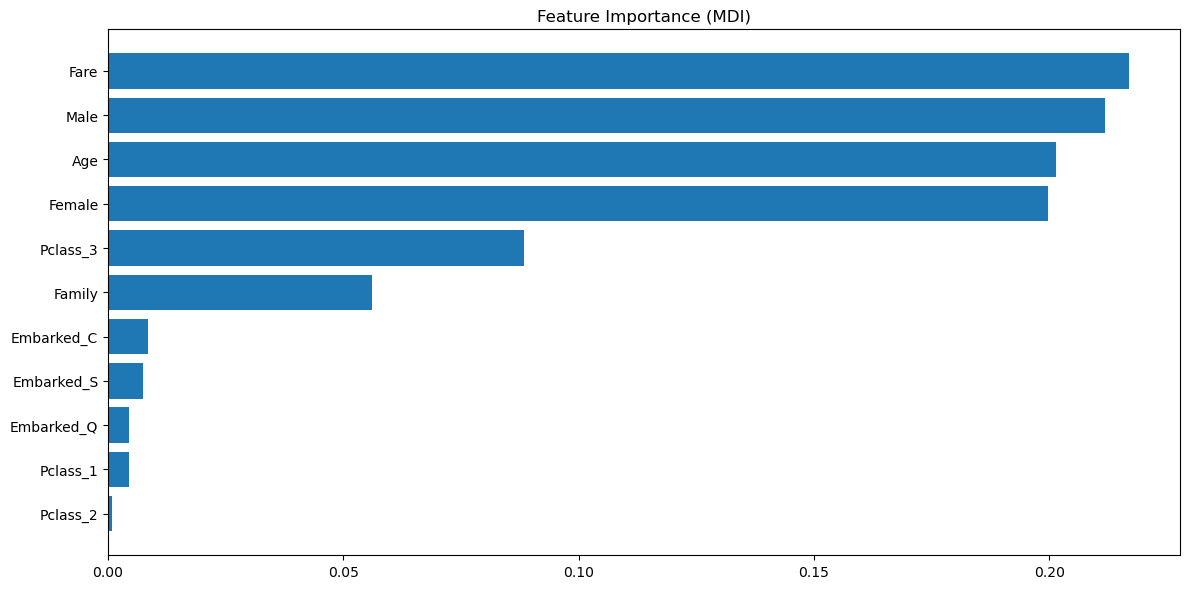

# 2. Feature engineering & Feature selection

- #### 시각화를 통해 각 독립변수가 종속변수(생존여부) 간의 관계 파악 

In [8]:
# 데이터 탐색을 위한 원본 데이터 70:30 비율로 split
train_df, test_df = model_selection.train_test_split(titan_df, test_size=0.3, random_state=0)

### Pclass

In [9]:
# 배의 클래스(1>2>3)
train_df.Pclass.value_counts()

3    335
1    156
2    132
Name: Pclass, dtype: int64

findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.


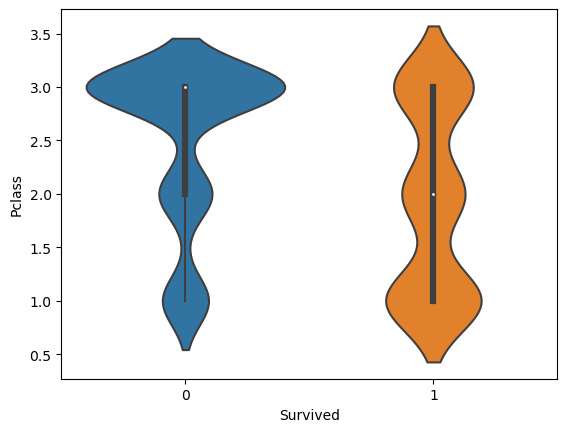

In [10]:
sns.violinplot( x=train_df['Survived'], y=train_df['Pclass'])
plt.show()

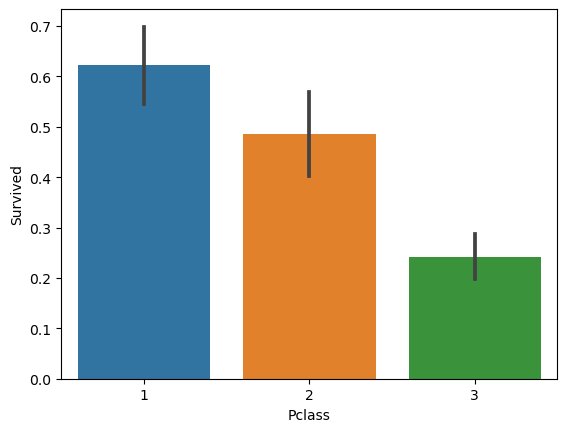

In [11]:
sns.barplot(x=train_df.Pclass, y=train_df.Survived)
plt.show()

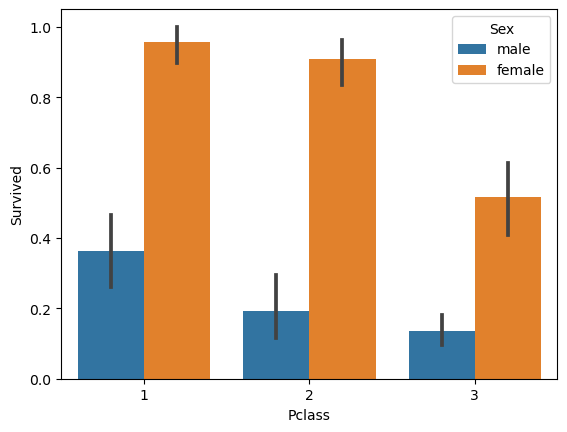

In [12]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_df)
plt.show()

### Age

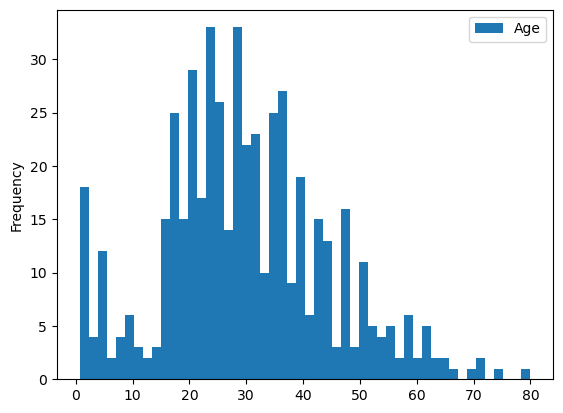

In [13]:
# 승객 연령 분포 (20-40대 사이가 가장 많음)
train_df.plot(kind="hist", y="Age", bins=50)
plt.show()

In [14]:
# Age컬럼의 기술 통계
train_df.Age.describe()

count    502.000000
mean      29.915339
std       14.506994
min        0.670000
25%       21.000000
50%       29.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

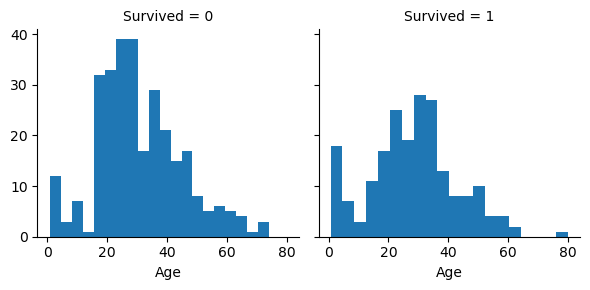

In [15]:
# 생존여부 별 승객 연령 분포 확인

age_histo = sns.FacetGrid(train_df, col='Survived')
age_histo.map(plt.hist, 'Age', bins=20)
plt.show()

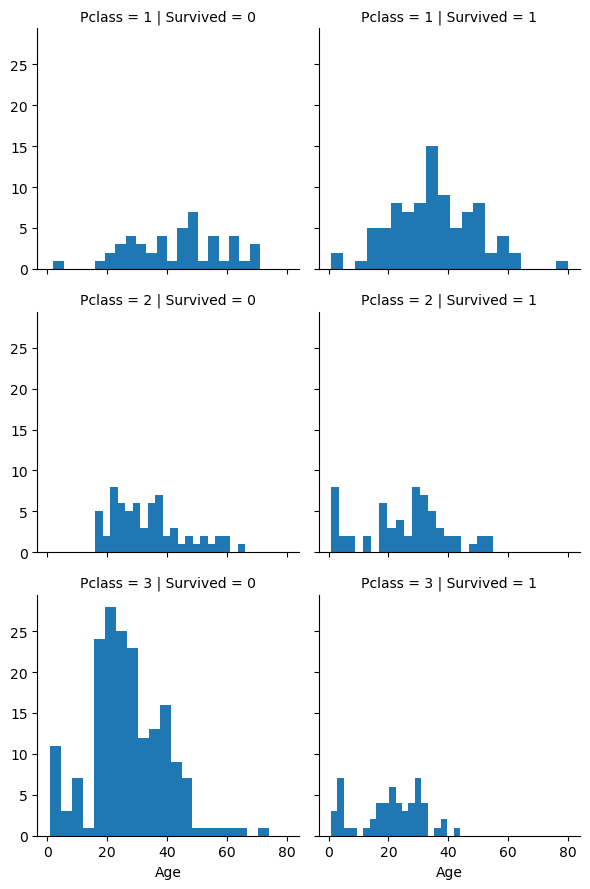

In [16]:
# Pclass 및 생존여부 별 연령대 분포 파악 
age_histo = sns.FacetGrid(train_df, row='Pclass',col='Survived')
age_histo.map(plt.hist, 'Age', bins=20)
plt.show()

### Sex

findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.


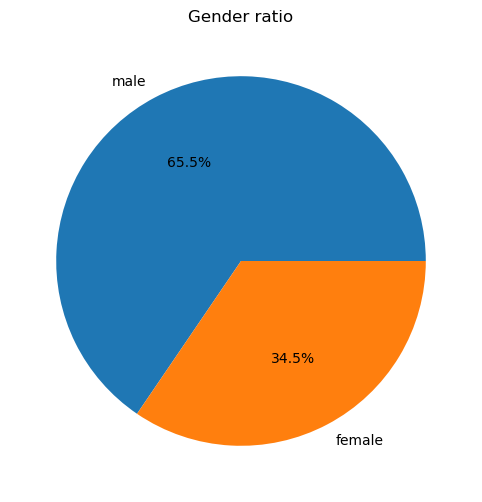

In [17]:
plt.figure(figsize=(8,6))
plt.plot(aspect='auto')
plt.pie(train_df['Sex'].value_counts(sort=False), labels=train_df['Sex'].value_counts(sort=False).index, autopct='%1.1f%%')
plt.title('Gender ratio')
plt.show()

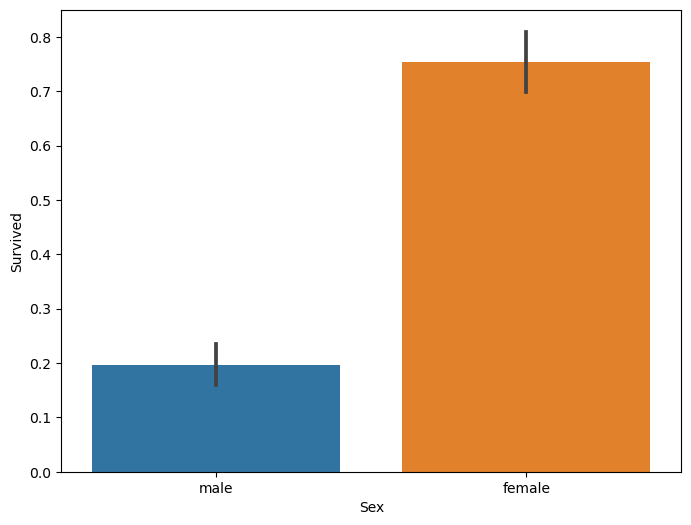

In [18]:
# 성별에 따른 생존률
plt.figure(figsize=(8,6))
sns.barplot(train_df.Sex, train_df.Survived)
plt.show()

### Fare

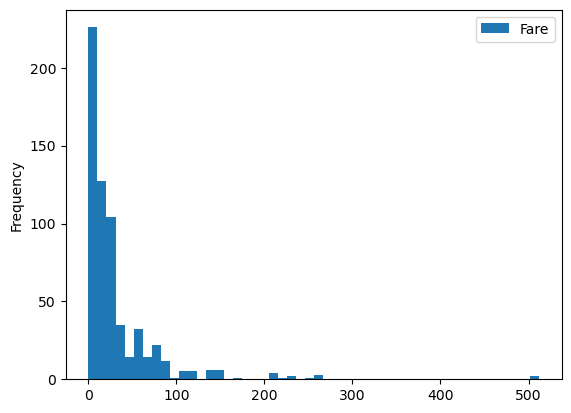

In [19]:
# fare
train_df.plot(kind="hist", y="Fare", bins=50)
plt.show()

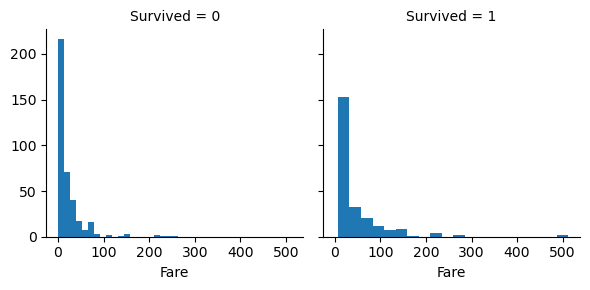

In [20]:
age_histo = sns.FacetGrid(train_df, col='Survived')
age_histo.map(plt.hist, 'Fare', bins=20)
plt.show()

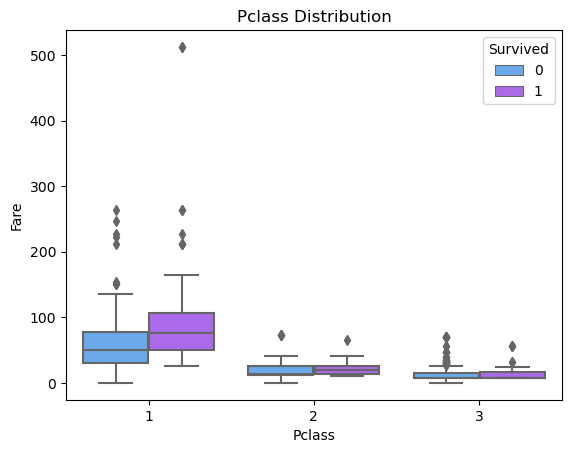

In [21]:
# Grouped boxplots by seaborn
plt.title("Pclass Distribution")
sns.boxplot(x="Pclass", 
            y="Fare", 
            hue="Survived",
            palette='cool',
            data=train_df)

plt.show()

### SibSp & Parch

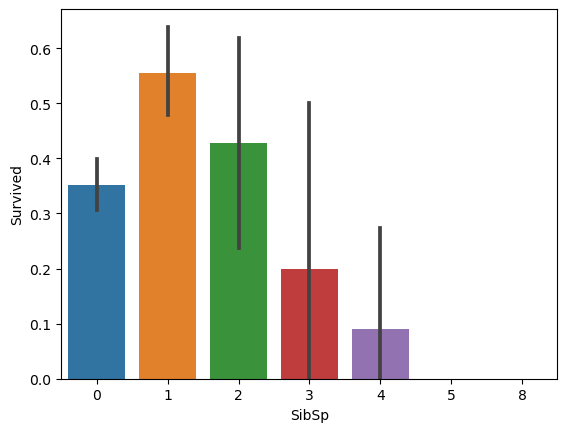

In [22]:
sns.barplot(train_df.SibSp, train_df.Survived)
plt.show()

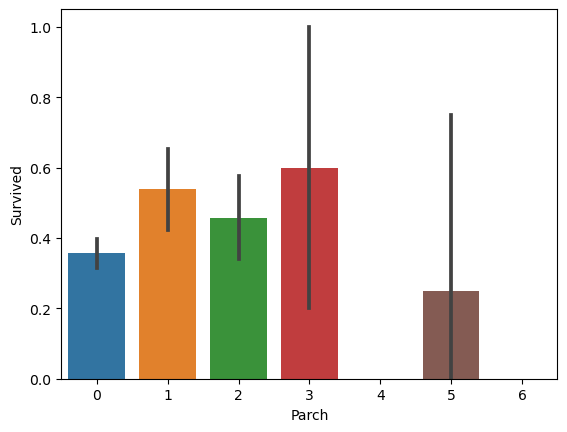

In [23]:
sns.barplot(train_df.Parch, train_df.Survived)
plt.show()

In [24]:
# 형제, 자매, 배우자의 수 + 부모, 자녀의 수를 합쳐 파생컬럼 생성 
titan_test = titan_df
titan_test['family'] = titan_test.SibSp + titan_df.Parch

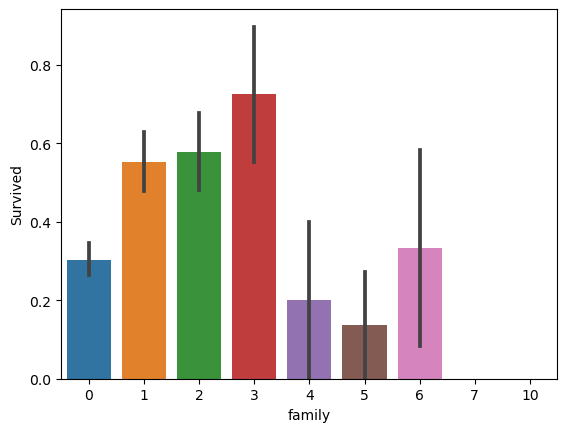

In [25]:
sns.barplot(titan_test.family, titan_test.Survived)
plt.show()

### Embarked

In [26]:
# 어디서 탔는 지에 따라 생존률이 달라질까? 
embarked_df = pd.DataFrame(round(titan_df.groupby(['Embarked'])['Survived'].value_counts(normalize=True), 2))
embarked_df

Survived
Embarked Survived          
C        1             0.55
         0             0.45
Q        0             0.61
         1             0.39
S        0             0.66
         1             0.34

In [27]:
pd.DataFrame(round(titan_df.groupby(['Embarked'])['Pclass'].value_counts(normalize=True), 2))

Pclass
Embarked Pclass        
C        1         0.51
         3         0.39
         2         0.10
Q        3         0.94
         2         0.04
         1         0.03
S        3         0.55
         2         0.25
         1         0.20

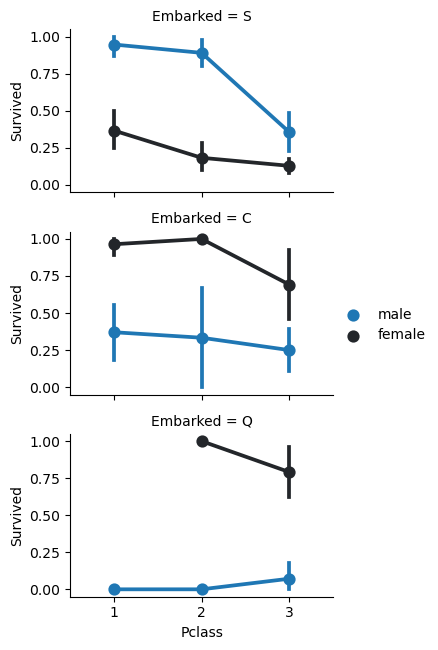

In [28]:
# 승선지에 따라서 Pclass별로 여성 및 남성의 생존율이 다르게 나타날까? 
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
grid.add_legend()

<br>

# 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [29]:
# Age에 랜덤하게 백분위수 25%~75%까지의 값을 랜덤하게 대치하기 위한 함수
def replace_age(age_quantile_25, age_quantile_75):
    return np.random.randint(age_percentiles_25, age_percentiles_75)

In [30]:
# Age의 백분위수 25%
age_percentiles_25 = titan_df.Age.quantile(.25)
# Age의 백분위수 75%
age_percentiles_75 = titan_df.Age.quantile(.75)

# Age에 랜덤하게 백분위수 25%~75%까지의 값을 랜덤하게 대치
titan_df.Age = titan_df.Age.apply(lambda x : replace_age(age_percentiles_25, age_percentiles_75) if pd.isna(x) else x)

In [31]:
# Embarked에 2개의 결측치 제거
titan_df.dropna(subset=['Embarked'], inplace=True)

In [32]:
# 필요없는 컬럼 제거
titan_df.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

# target(Survived) column만 나눠놓은 것
target_df = titan_df['Survived']
# Survived column을 지우고 실제로 train_split 할 데이터
data_df = titan_df.drop(columns=['Survived'])


In [33]:
# 결측치 처리 됐는 지 확인
titan_df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
family      0
dtype: int64

In [34]:
# 7:3의 비율, seed는 0으로 데이터를 train과 test로 나누는 과정
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_df, target_df,
                                                                    stratify=target_df,
                                                                    test_size=0.3,
                                                                    random_state=42)

In [35]:
# 변수 유형 별 pipeline 적용

# 연속형 데이터
numeric_features = ['SibSp', 'Parch', 'Age', 'Fare']
# 연속형 데이터 encoder
numeric_transformer = StandardScaler()
# 범주형 데이터
categorical_features = ['Sex', 'Pclass', 'Embarked']
# 범주형 데이터 encoder
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
)

In [36]:
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [37]:
# x_train데이터 학습시키는 과정
preprocessor_pipe.fit(x_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SibSp', 'Parch', 'Age',
                                                   'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]))])

In [38]:
# x_train의 학습을 토대로 One-HotEncoding(), StandardScaler() 적용
x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

In [39]:
# 컬럼명 변경
x_train_encoding_df = pd.DataFrame(x_train_transformed, columns=['SibSp', 'Parch', 'Age', 'Fare', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])
x_test_encoding_df =  pd.DataFrame(x_test_transformed, columns=['SibSp', 'Parch', 'Age', 'Fare', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])


In [40]:
# 파생컬럼(Family) 추가 한 데이터프레임 생성 
new_x_train = x_train 
new_x_test = x_test 

new_x_train['Family'] = new_x_train.SibSp + new_x_train.Parch
new_x_test['Family'] = new_x_test.SibSp + new_x_test.Parch

In [41]:
# 기존 SibSp, Parch 컬럼 제거
new_x_train.drop(columns=['SibSp', 'Parch'], inplace=True)
new_x_test.drop(columns=['SibSp', 'Parch'], inplace=True)

In [42]:
# 연속형 데이터
new_numeric_features = ['Family', 'Age', 'Fare']
# 연속형 데이터 encoder
numeric_transformer = StandardScaler()
# 범주형 데이터
categorical_features = ['Sex', 'Pclass', 'Embarked']
# 범주형 데이터 encoder
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

new_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, new_numeric_features),
        ('cat', categorical_transformer, categorical_features)],
)

In [43]:
new_preprocessor_pipe = Pipeline(steps=[('preprocessor', new_preprocessor)])

In [44]:
# x_train데이터 학습시키는 과정
new_preprocessor_pipe.fit(new_x_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Family', 'Age', 'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]))])

In [45]:
# x_train의 학습을 토대로 One-HotEncoding(), StandardScaler() 적용
new_x_train_transformed = new_preprocessor_pipe.transform(new_x_train)
new_x_test_transformed = new_preprocessor_pipe.transform(new_x_test)

In [46]:
# 컬럼명 변경
x_train_encoding_new = pd.DataFrame(new_x_train_transformed , columns=['Family', 'Age', 'Fare', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])
x_test_encoding_new =  pd.DataFrame(new_x_test_transformed , columns=['Family', 'Age', 'Fare', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])

<br>

# 3. Train the model


## Stacking
HPO(Hyper-parameter optimization) : GridSearch 사용


#### 파생컬럼(Family) 미포함

#### 1단계.
1. ExtraTrees
2. RandomForest
3. XGB
4. DecisionTree
5. LogisticReression
6. SupportVectorMachine

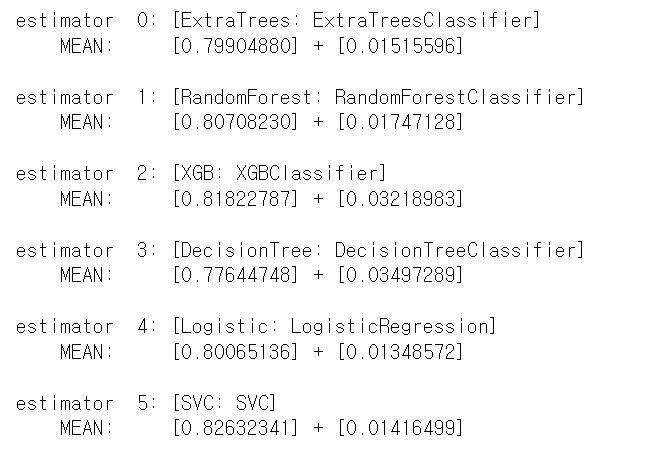

#### 2단계.
- XGB
- Prediction score: 0.80

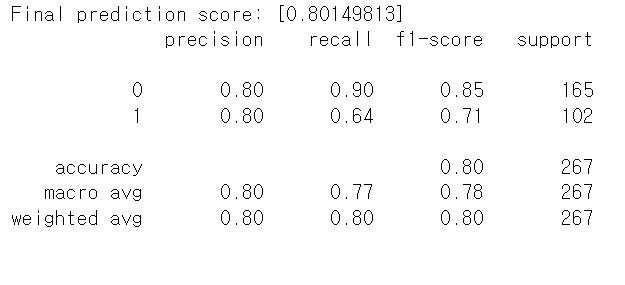

#### 파생컬럼(Family) 포함

#### 1단계.
1. ExtraTrees
2. RandomForest
3. XGB
4. DecisionTree
5. LogisticReression
6. SupportVectorMachine

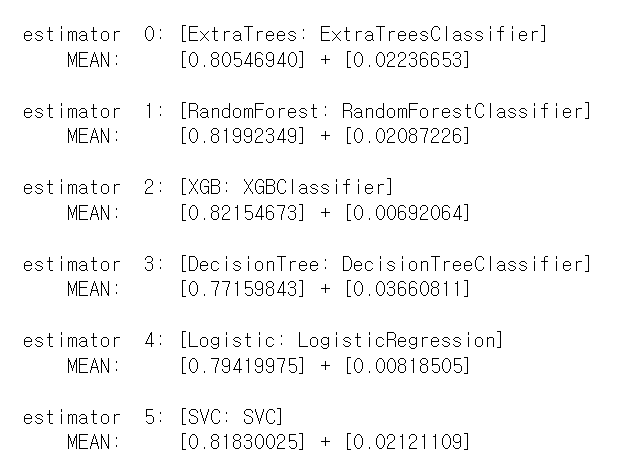

#### 2단계
- XGB
- Pediction score: 0.80

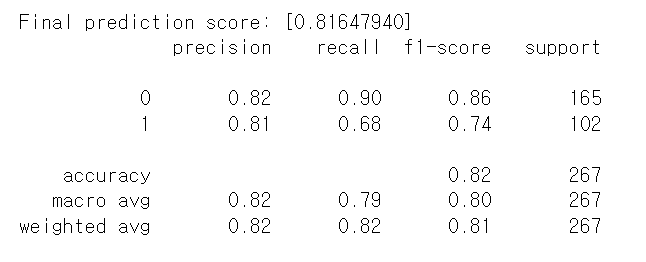

> 파생컬럼 추가 여부와 관계 없이 SVC 모델이 가장 평균 정확도가 높게 나오며, 2단계에서 XGB를 돌렸을 때 파생컬럼을 포함하지 않았을 때의 Prediction score가 약간 높게 나왔음

## Logistic Regression

#### 파생컬럼(Family)미포함
- Accuracy : 0.7977
- ROC_AUC  : 0.8328

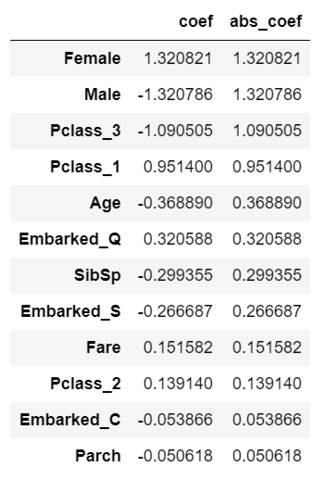

#### 파생컬럼(Family) 포함
- Accuracy : 0.8014
- ROC_AUC : 0.8321

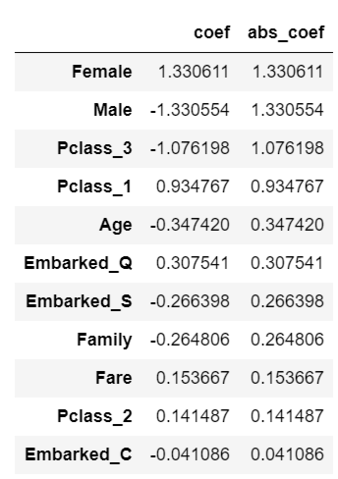

> 파생컬럼을 추가했을 때 정확도 및 AUC값이 더 높게 나타남

## DecisionTree Classifier

#### 파생컬럼(Family) 미포함
- Accuracy: 0.75

#### 파생컬럼(Family) 포함
- Accuracy: 0.78

## Support Vector Machine & GridSearch

#### 파생컬럼(Family) 미포함
- The best parameters are  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
- Accuracy: 0.813

#### 파생컬럼(Family) 포함
- The best parameters are  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
- Accuracy: 0.809

## XG Boost - Gradient Boosting

### Gradient Boosting classification


#### 파생컬럼(Family) 미포함
- Accuracy: 0.7978
- ROC curve: 0.83
- Variable Importance Top5: Male > Age > Fare > Female > Pclass_3

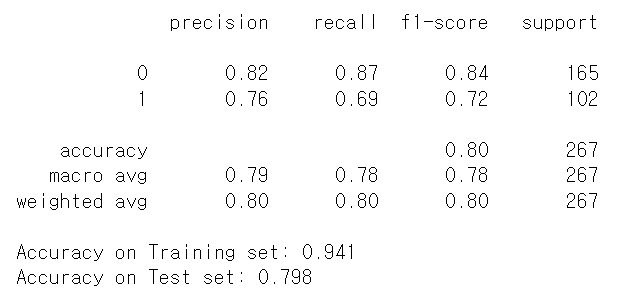

#### 파생컬럼(Family) 포함
- Accuracy: 0.8127
- ROC curve: 0.84
- Variable Importance Top5: Fare > Male > Age > Female > Pclass_3

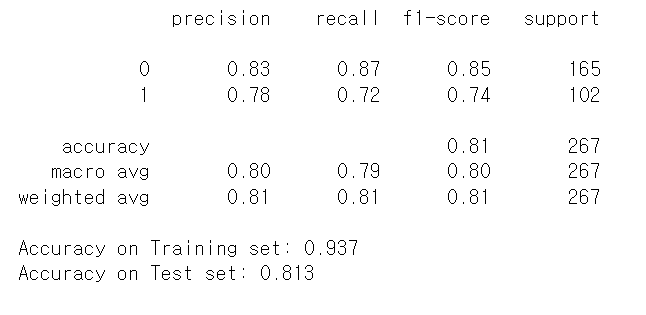

> Training set에 한해서는 파생컬럼을 포함하지 않았을 때가 정확도가 더 높게 나타나지만, Test set에서는 파생컬럼을 생성했을 때 더 높게 나옴

[ 파생컬럼 생성 전 ]
- Stacking을 통한 모델 비교: SVM > XGB > RandomForest > ExtraTrees > LogisticReression > DecisionTree 
- 세부적인 모델링을 통한 비교: SVM > XGB > LogisticReression > DecisionTree 

> **두 가지 경우 모두 SVM이 가장 높고 Decision Tree가 가장 낮게 나옴**

[ 파생컬럼 생성 후 ] 
- Stacking을 통한 모델 비교: SVM > XGB > RandomForest > ExtraTrees > LogisticReression > DecisionTree 
- 세부적인 모델링을 통한 비교: XGB > SVM > LogisticReression > DecisionTree

# 4. 향후 과제 

## 변수별 추가 분석
1. Fare
- 배의 클래스(Pclass)에 따라 다르게 측정되었을 것으로 추측 가능하나, 해당 컬럼을 기준으로 오름차순으로 정렬해 봤을 때 0$인 경우 또한 존재하였으며 Pclass 등급과 별개로 가격이 높거나 혹은 낮은 경우가 다수 확인되었으며 굉장히 높은 값을 지불한 소수의 승객 존재(값이 너무 낮거나 높은 값은 이상치로 보아야 하는 것인지, Fare이 어떠한 기준으로 측정된 것인지 파악하기 어려움)

2. Name
- name 분류를 Mrs, Mr, 둘다 아닌 것, 세가지로 구분이 가능한데 이것을 통해 대략적인 나이를 추정할 수 있을 것 같다는 추측

3. Cabin
- 숙박했던 방번호라면, 형제, 부모가 없는 사람 중 방번호를 3개 가지고 있는 사람이 있는가하면, 방번호가 겹치는 상황이 존재하는데, 이 경우 Cabin 결측치를 어떤 식으로 처리하는 것이 좋은 지에 대한 고민 필요 

4. 다변량 분석 
- 각 독립변수와 종속변수 간의 관계만 시각화하는 것이 아니라 독립변수들 간 어떠한 관계가 있는 지 다변량 분석 가능

## 새로운 컬럼 생성 
- Family 외에도 혼자 탑승한 승객들을 모아 Alone 컬럼을 생성하는 등 기타 다양한 방식으로 컬럼 생성 가능  

## 상관관계 도출 
- 종속변수와 독립변수 간 상관관계 도출
> 범주형-범주형: Survived-Pclass, Embarked -> Phi Correlation (각 범주 변수를 0과 1로 바꾼 다음, 이 둘 간의 Pearson 상관계수로 계산)
> 범주형-연속형: Survived-Age, SibSp, Parch -> Point biserial Correlation (이분변수를 0과 1로 코딩한 다음 Peason 상관계수를 계산)

- 독립변수 간 상관관계 분석
> 범주형: Pclass, Embarked
> 연속형: Age, SibSp, Parch 

    > 범주형, 연속형 변수 섞여있으므로 Point biserial Correlation 

## 모델링
- KNN or k-Nearest Neighbors, Perceptron, Artificial neural network 등 추가적인 머신러닝, 딥러닝 모델링 가능 
